<h1>纵览 | Overview<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Enhanced-3D-Zonal-Segmentation-of-the-Prostate-on-MRI-via-Enhanced-Weight-Standardization-and-Group-Normalization" data-toc-modified-id="Enhanced-3D-Zonal-Segmentation-of-the-Prostate-on-MRI-via-Enhanced-Weight-Standardization-and-Group-Normalization-1">Enhanced 3D Zonal Segmentation of the Prostate on MRI via Enhanced Weight-Standardization and Group-Normalization</a></span></li><li><span><a href="#基于的Weight-Standardization和Group-Normalization在前列腺MRI数据集上的三维区块分割" data-toc-modified-id="基于的Weight-Standardization和Group-Normalization在前列腺MRI数据集上的三维区块分割-2">基于的Weight-Standardization和Group-Normalization在前列腺MRI数据集上的三维区块分割</a></span><ul class="toc-item"><li><span><a href="#背景介绍-|-Introduction" data-toc-modified-id="背景介绍-|-Introduction-2.1">背景介绍 | Introduction</a></span><ul class="toc-item"><li><span><a href="#动机-|-Motivations" data-toc-modified-id="动机-|-Motivations-2.1.1">动机 | Motivations</a></span></li><li><span><a href="#主要贡献-|-Main-contributions" data-toc-modified-id="主要贡献-|-Main-contributions-2.1.2">主要贡献 | Main contributions</a></span></li></ul></li><li><span><a href="#数据集与所提方法-|-Datasets-&amp;-Proposed-methods" data-toc-modified-id="数据集与所提方法-|-Datasets-&amp;-Proposed-methods-2.2">数据集与所提方法 | Datasets &amp; Proposed methods</a></span><ul class="toc-item"><li><span><a href="#数据集-|-Dataset:-Task05_Prostate" data-toc-modified-id="数据集-|-Dataset:-Task05_Prostate-2.2.1">数据集 | Dataset: Task05_Prostate</a></span></li><li><span><a href="#基准-|-Baseline:-3D-U-Net-[3]" data-toc-modified-id="基准-|-Baseline:-3D-U-Net-[3]-2.2.2">基准 | Baseline: 3D U-Net [3]</a></span></li><li><span><a href="#所提方法-|-Proposed-architecture:-3D-UWG-Net" data-toc-modified-id="所提方法-|-Proposed-architecture:-3D-UWG-Net-2.2.3">所提方法 | Proposed architecture: 3D UWG-Net</a></span></li></ul></li><li><span><a href="#实验评估-|-Experiments-&amp;-Evaluation" data-toc-modified-id="实验评估-|-Experiments-&amp;-Evaluation-2.3">实验评估 | Experiments &amp; Evaluation</a></span><ul class="toc-item"><li><span><a href="#实现细节-|-Implementation-details" data-toc-modified-id="实现细节-|-Implementation-details-2.3.1">实现细节 | Implementation details</a></span></li><li><span><a href="#小范例-|-Small-example" data-toc-modified-id="小范例-|-Small-example-2.3.2">小范例 | Small example</a></span></li><li><span><a href="#评价指标-|-Evaluation-criteria" data-toc-modified-id="评价指标-|-Evaluation-criteria-2.3.3">评价指标 | Evaluation criteria</a></span></li><li><span><a href="#结果可视化-|-Result-visualization" data-toc-modified-id="结果可视化-|-Result-visualization-2.3.4">结果可视化 | Result visualization</a></span></li><li><span><a href="#充分实验-|-Quantitative-studies" data-toc-modified-id="充分实验-|-Quantitative-studies-2.3.5">充分实验 | Quantitative studies</a></span></li></ul></li><li><span><a href="#总结与未来工作-|-Conclusion-&amp;-Future-work" data-toc-modified-id="总结与未来工作-|-Conclusion-&amp;-Future-work-2.4">总结与未来工作 | Conclusion &amp; Future work</a></span></li><li><span><a href="#参考文献-|-References" data-toc-modified-id="参考文献-|-References-2.5">参考文献 | References</a></span></li></ul></li></ul></div>

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../') 
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import torch.nn.functional as F
# U-Net
# from model_origin import *
# UG-Net
# from model_gn import *
# UWG-Net
from model import *
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

# from utils import test_single_case_baselineunet, dsc, multiclass_dice_loss, test_single_case_CasNetv0_3, dice_loss
from utils import test_single_case_baselineunet, dsc, multiclass_dice_loss, dice_loss
from utils_hyj import count_dir_file, convert_path, multi_slice_viewer, plot_loss
from data import ProstateDataset, ToTensor, Normalization, RandomCrop, CreateOnehotLabel, RandomAug

# pip install torchsummary
# from torchsummary import summary

# ubuntu: sudo apt install graphviz
# win: conda install graphviz
# pip install torchviz
# https://github.com/szagoruyko/pytorchviz/blob/master/examples.ipynb
from torchviz import make_dot, make_dot_from_trace

torch.__version__

'1.0.1'

# Tongji Univ. Deep Learning Final Project | 深度学习期末项目

## Enhanced 3D Zonal Segmentation of the Prostate on MRI via Enhanced Weight-Standardization and Group-Normalization

## 基于的Weight-Standardization和Group-Normalization在前列腺MRI数据集上的三维区块分割

<font size="3">
    
**何宇杰，1551862，机械与能源工程学院**

</font> 

### 背景介绍 | Introduction

#### 动机 | Motivations 

近些年来，图像分割领域逐年取得巨大的进展，但是对于医疗图像处理分割部分，性能仍然有待提高

- 已标注和公开的三维数据少以及单个案例的较大数据量（约为140x140x70）使得限制了模型只能进行少样本学习

- 在这种情况下，模型分割的表现与专业医生的所标注的ground-truth有较大差距

#### 主要贡献 | Main contributions 

- 结合19年提出的[Weight-standardization](https://arxiv.org/abs/1903.10520)实现了在MRI图像分割性能的提升
- 在现有公开前列腺数据集上进行充分验证，并进行了消融实验

### 数据集与所提方法 | Datasets & Proposed methods

#### 数据集 | Dataset: Task05_Prostate

- 数据集简介

    - consisted of 48 multi-parametric MRI studies provided by Radboud University (The Netherlands) reported in a previous segmentation study [1]

    - Manual segmentation of the whole prostate from transverse T2-weighted scans with resolution 0.6 x 0.6 x 4 mm and the apparent diffusion coefficient (ADC) map (2 x 2 x 4 mm) was used.

    - 前列腺数据集由荷兰Radboud大学提供的48项多参数MRI研究组成

    - 使用横向T2加权扫描以0.6 x 0.6 x 4 mm分辨率和表观扩散系数（ADC）图（2 x 2 x 4 mm）对整个前列腺进行手动分割。

    - 目前是作为[Medical Segmentation Decathlon Datasets](https://academictorrents.com/details/274be65156ed14828fb7b30b82407a2417e1924a) 医疗分割十项全能挑战赛的第五个数据集 [2]

- 官方数据集中：

    - labelsTr 对应32份训练集标签
    - imagesTr  对应32份训练集数据
    - imagesTs   对应16份测试集数据(**需要提交至网络进行评估**)



因此，在本次实验中，我们则是对于现有32个数据集进行手动分割

前10个数据集作为当前项目的测试集，如下所示：

```
prostate_00, prostate_01, prostate_02, prostate_04, prostate_06, prostate_07, prostate_10, prostate_13, prostate_14, prostate_16
```

后22个数据集作为当前项目的测试集，如下所示：
```
prostate_17, prostate_18, prostate_20, prostate_21, prostate_24, prostate_25, prostate_28, prostate_29, prostate_31, prostate_32, prostate_34, prostate_35, prostate_37, prostate_38, prostate_39, prostate_40, prostate_41, prostate_42, prostate_43, prostate_44, prostate_46, prostate_47
```

- 初步载入数据集

In [3]:
# 数据集路径
train_list_path = '../lists/prostate_train.list'
test_list_path = '../lists/prostate_test.list'
train_data_path = '../double_phase_bb_pad32'
test_data_path = '../double_phase_bb_pad32'
res_data_base = '../results/'

In [4]:
_, _, _, filelist = count_dir_file(train_data_path)

image0 = np.load(filelist[0])['imageA'].astype(np.float32)
label0 = np.load(filelist[0])['label'].astype(np.float32)
print('The shape of 1st case is {}'.format(image0.shape))

image1 = np.load(filelist[1])['imageA'].astype(np.float32)
label1 = np.load(filelist[1])['label'].astype(np.float32)
print('The shape of 2nd case is {}'.format(image1.shape))

The shape of 1st case is (124, 139, 54)
The shape of 2nd case is (137, 157, 72)


In [5]:
# label class
len(np.unique(label0[:,:,:]))

3

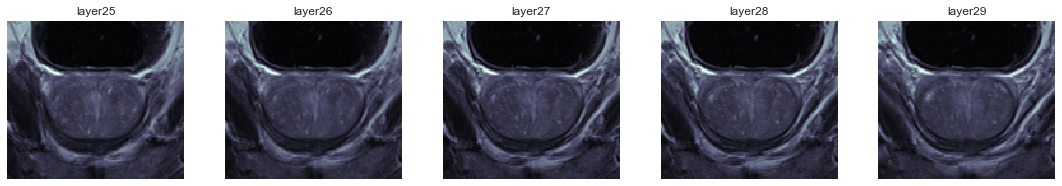

In [6]:
# 多层T2图像打印
import matplotlib.pyplot as plt

# low_range =  0
# high_range = 1000.0
start = 25

plt.figure(figsize=(15, 75))
for i in range(5):
    # 归一化操作，其实已经预处理了
    layer = start + i - 1
    img = image0[:,:,layer]
    # high_range = np.max(img)
    # img = np.round((img - low_range) / (high_range - low_range) * 255.0)
    plt.subplot(1,5,i+1)
    # 使用cmap='bone'，产生造影效果
    plt.imshow(img, cmap='bone')
    plt.tight_layout()
    plt.xticks([])  #去掉x轴
    plt.yticks([])  #去掉y轴
    plt.axis('off')  #去掉坐标轴
    plt.title('layer'+str(layer+1))

plt.show()

- 借鉴已有代码，重写`def multi_slice_viewer`

> 参考 [Viewing 3D Volumetric Data With Matplotlib - DataCamp](https://www.datacamp.com/community/tutorials/matplotlib-3d-volumetric-data)

<Figure size 1440x1440 with 0 Axes>

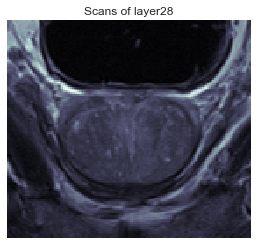

In [7]:
# 查看中间层
multi_slice_viewer(image0)

C:\Users\HYJ\Anaconda3\envs\py37fastai10\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


<Figure size 1440x3240 with 0 Axes>

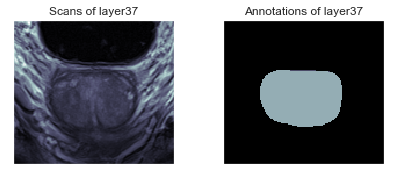

In [8]:
# 查看第26层的图像和标签
multi_slice_viewer(image0, label0, preds = None, index = 36)

#### 基准 | Baseline: 3D U-Net [3]

> C¸ i¸cek O., et al. 3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation, MICCAI 2016

- 面临问题：

    - Volumetric data is abundant in biomedical data analysis. Annotation of such data with segmentation labels causes difficulty
    - 在生物医疗图像中，体素信息非常丰富，但是标注异常困难。因此使用完全标注的三维图像得到训练数据，非常不可行。

- 解决方法：

    - 使用少量分割数据，来生成整体稠密的分割结果
    - 使用完全新颖的3D架构，3维信息作为输入，然后中间设计的操作也都是三维 the network proposed in this paper takes 3D volumes as input and processes them with corresponding 3D operations, in particular, 3D convolutions, 3D max pooling, and 3D up-convolutional layers.
    - 与U-Net不同的是，在3dmaxpooling丢失信息前的3dconv先进行维度扩增（扩增回路则是使用反操作，先压缩维度卷积再3dmaxpooling），来实现avoid bottlenecks in the network architecture 
    - 使用Batch Nnormalization层来加速训练时的收敛
    - 同样使用特别设计的 weighted loss function 
    - 结合特殊数据增广形式 （apply a smooth dense deformation field on both data and ground truth labels），然后相关数据使用的插值方法为：B-spline interpolation

- 实验：

    最后实验部分，分别进行了Semi-Automated Segmentation半标注分割，通过进行少数的标注，实现整个三维结构的分割；同时也进行了Full-Automated Segmentation全自动分割，通过再小数据集上训练，以实现在大数据集上的泛化。

**使用Batch Nnormalization在一定程度上可以加速训练时的收敛，但是由于现有Prostate数据集的特殊，直接应用的性能表现有待提高**

模型计算图导出： Failed on Windows issue: [“RuntimeError: Make sure the Graphviz executables are on your system's path” after installing Graphviz 2.38](https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft)

In [ ]:
# ubuntu
# net_cpu = Baseline_UNET(in_channels=1, out_channels=num_classes)
# x = torch.randn(1,1,96,96,32)
# dot = make_dot(net_cpu(x), params=dict(net_cpu.named_parameters()))

In [ ]:
# dot.format = 'png'
# dot.render('Baseline_UNet')

![UNet](./U-Net.png)

#### 所提方法 | Proposed architecture: 3D UWG-Net

- 如何理解 Weight-standardization

    - WS is targeted at the micro-batch training setting where each GPU typically has only 1-2 images for training. 

    - The micro-batch training setting is hard because small batch sizes are not enough for training networks with Batch Normalization (BN),

    基本思想和BN是一致：尽量保证映射的平滑性。不过BN是通过对反馈的信号的约束来间接调整w，Weight-standardization是直接调整卷积层对应权重w

- 工作原理

> 更多详情可见[Weight Standardization](https://arxiv.org/pdf/1903.10520.pdf)

$\hat{\boldsymbol{W}}=\left[\hat{\boldsymbol{W}}_{i, j} | \hat{\boldsymbol{W}}_{i, j}=\frac{\boldsymbol{W}_{i, j}-\mu_{\boldsymbol{W}_{i}, i}}{\sigma_{W_{i, j}+\epsilon}}\right]$

$\boldsymbol{y}=\hat{\boldsymbol{W}} * \boldsymbol{x}$

其中，$\mu_{\boldsymbol{W}_{i, .}}=\frac{1}{I} \sum_{j=1}^{I} \boldsymbol{W}_{i, j}, \quad \sigma_{\boldsymbol{W}_{i,}}=\sqrt{\frac{1}{I} \sum_{i=1}^{I}\left(\boldsymbol{W}_{i, j}-\mu_{\boldsymbol{W}_{i, \cdot}}\right)^{2}}$


在上述式子中， $\hat{\boldsymbol{W}}$ 卷积层的权重，* 是卷积运算。将图2 所示作为一个例子，WS方法不会直接在原始权重上进行优化，而是采用另一个函数 $\hat{\boldsymbol{W}}= \mathrm{WS}(\hat{\boldsymbol{W}})$来表示原始权重$\hat{\boldsymbol{W}}$，然后使用 SGD 算法来更新 W。

![ws_graph](./ws_graph.png)

- 与其他正则方法的比较

    - BN在batch的维度上norm，归一化维度为[N，H，W]，对batch中对应的channel归一化；
    - LN避开了batch维度，归一化的维度为[C，H，W]；
    - IN 归一化的维度为[H，W]；
    - 而GN介于LN和IN之间，其首先将channel分为许多组（group），对每一组做归一化，及先将feature的维度由[N, C, H, W]reshape为[N, G，C//G , H, W]，归一化的维度为[C//G , H, W]
    
    
![ws_graph](./normalization_comp.png)

其他方法是对于所输入的样本进行正则化，而Weight Standardization则是对于卷积核进行操作！

- 对应代码实现

> WS is able to match or outperform the performances of BN trained with large batch sizes with only few lines of code
>
> 实现简单，并且根据作者实验，在此基础上，引入GN能够进一步对于解决了BN式归一化对batch size依赖的影响有较大的帮助

```python
# Conv3d with weight standardization
class Conv3d(nn.Conv3d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv3d, self).__init__(in_channels, out_channels, kernel_size, stride,
                 padding, dilation, groups, bias)

    def forward(self, x):
        weight = self.weight
        # with weight_standardization
        weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2,
                                  keepdim=True).mean(dim=3, keepdim=True).mean(dim=4, keepdim=True)
        weight = weight - weight_mean
        std = weight.view(weight.size(0), -1).std(dim=1).view(-1, 1, 1, 1, 1) + 1e-5
        weight = weight / std.expand_as(weight)
        return F.conv3d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
```

结合[`CLASStorch.nn.GroupNorm(num_groups, num_channels, eps=1e-05, affine=True)`](https://pytorch.org/docs/stable/nn.html?highlight=groupnorm#torch.nn.GroupNorm) 在U-Net卷积block部分，将每一层分为16groups，如下所示：
```python
# ConvBlock with weight standardization and GroupNorm
class ConvBlock(nn.Module):
    # initial kernal_size is 3 and padding is 1
    def __init__(self, inplanes, planes, kernel_size=3,stride=1, padding = 1):
        super(ConvBlock, self).__init__()
        self.norm = lambda planes: nn.GroupNorm(16, planes)
        self.planes = planes
        self.inplanes = inplanes
        self.conv = Conv3d(inplanes, planes, kernel_size= kernel_size, stride= stride, padding = padding, bias=False)
        self.bn = self.norm(planes)
        self.relu = nn.ReLU(inplace=False)
        self.stride = stride
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
```



In [9]:
experiment = '50_test'

In [10]:
torch.backends.cudnn.benchmark=True
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# Max iterations, default = 40000
max_iterations = 50
base_lr = 0.01
num_classes = 3
batch_sz = 2 # 可以适当调大，根据使用卡的倍数
# Print per `print_iter` iterations, default = 100
print_iter = 5
# Save per `save_iter` iterations, default = 10000
save_iter = 25

In [11]:
criterion = multiclass_dice_loss
snapshot_path = '../models' 
snapshot_prefix = 'UWG-Net_' + experiment

In [12]:
net = Baseline_UNET(in_channels=1, out_channels=num_classes).cuda()

In [13]:
dataset = ProstateDataset(list_file = train_list_path, 
                                    root_dir = train_data_path,
                                    transform = transforms.Compose([
                                    Normalization(),
                                    # RandomAug(),
                                    RandomCrop((96,96,32)),
                                    CreateOnehotLabel(3),
                                    ToTensor(),
                                    ]))

In [14]:
net.train()
net_parallel = nn.DataParallel(net)

In [15]:
train_loader = torch.utils.data.DataLoader(dataset,
             batch_size=batch_sz, shuffle=True,
             num_workers=4) # in 4 gpu!
net_parallel.train()

DataParallel(
  (module): Baseline_UNET(
    (SegNet): MyUNet(
      (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): GroupNorm(16, 32, eps=1e-05, affine=True)
      (relu): ReLU(inplace)
      (layer1): Sequential(
        (0): ResConvBlock(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
          (bn): GroupNorm(16, 32, eps=1e-05, affine=True)
          (relu): ReLU()
          (downsample): Sequential(
            (0): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False)
            (1): GroupNorm(16, 32, eps=1e-05, affine=True)
          )
        )
        (1): ResConvBlock(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (bn): GroupNorm(16, 32, eps=1e-05, affine=True)
          (relu): ReLU()
        )
        (2): ResConvBlock(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), 

In [ ]:
# ubuntu
# net_cpu = Baseline_UNET(in_channels=1, out_channels=num_classes)
# x = torch.randn(1,1,96,96,32)
# dot = make_dot(net_cpu(x), params=dict(net_cpu.named_parameters()))

In [ ]:
# dot.format = 'png'
# dot.render('UWG-Net')

![UWG-Net](./UWG-Net.png)

### 实验评估 | Experiments & Evaluation

#### 实现细节 | Implementation details

- `dsc.py`，`dice_loss.py` 与 `multiclass_dice_loss.py` 

$\mathrm{DL}_{2}=1-\dfrac{\sum_{n=1}^{N} p_{n} r_{n}+\epsilon}{\sum_{n=1}^{N} p_{n}+r_{n}+\epsilon}-\dfrac{\sum_{n=1}^{N}\left(1-p_{n}\right)\left(1-r_{n}\right)+\epsilon}{\sum_{n=1}^{N} 2-p_{n}-r_{n}+\epsilon}$


```python
def dsc(x, y):
    #x = x.float()
    #y = y.float()
    # print("prediction shape", x.shape)
    # print("gt shape", y.shape)
    assert(x.shape == y.shape)
    if y.sum() == 0:
      print('no label')
      return 0
    return 2.0 * (x * y).sum() / (x.sum() + y.sum())

def dice_loss(z,y):
    intersect = torch.sum(z * y)
    y_sum = torch.sum(y)
    z_sum = torch.sum(z)
    loss = 1 - (2 * intersect / (z_sum + y_sum + 1e-5))
    return loss

def multiclass_dice_loss(x, y, thresh = 100):
    assert(x.size() == y.size())
    loss = 0
    count = 0
    for c in range(x.size()[1]):
        if y[:,c:,:,:].sum() > thresh:
            loss += dice_loss(x[:,c,:,:,:], y[:,c,:,:,:])
            count += 1
    # 计算平均dice
    loss = loss / count
    return loss
```

与Prostate数据集读入相关的代码

```python
dataset = ProstateDataset(list_file = train_list_path, 
                                    root_dir = train_data_path,
                                    transform = transforms.Compose([
                                    Normalization(),
                                    # RandomAug(),
                                    RandomCrop((96,96,32)),
                                    CreateOnehotLabel(3),
                                    ToTensor(),
                                    ]))
```

- `ProstateDataset.py`

```python
class ProstateDataset(Dataset):
  """ Prostate Dataset """

  def __init__(self, list_file, root_dir, transform=None):
    """
    Args:
      list_file (string) : List of the image files
      root_dir (string) : Directory of images
      transform (callable, optional) : Optional transform to be applied on a sample
    """
    self.image_list = open(list_file).readlines()
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.image_list)

  def __getitem__(self, idx):
    img_name = os.path.join(self.root_dir, self.image_list[idx].strip('\r\n') + '.npz')
    #img_name = os.path.join(self.root_dir, self.image_list[idx].split('.')[0] + '.npz')
    # .npz的数据里面存着 imageA, imageV, label三个key
    # imageA 对应着 T2
    image = np.load(img_name)['imageA'].astype(np.float32)
    label = np.load(img_name)['label'].astype(np.float32)
    # print(img_name)
    # print("shape of image", image.shape)
    # print("shape of label", label.shape)

    sample = {'image': image, 'label': label}

    if self.transform:
      sample = self.transform(sample)
    # print("shape of image", sample['image'].shape)

    return sample
```

- `RandomCrop.py`

随机裁剪，用于训练时的统一输入

```python
class RandomCrop(object):

    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        pos1, pos2, pos3 = random.uniform(0,1), random.uniform(0,1), random.uniform(0,1)

        (w, h, d) = image.shape
        w1 = int(pos1 * (w - self.output_size[0]))
        sw = self.output_size[0]
        h1 = int(pos2 * (h - self.output_size[1]))
        sh = self.output_size[1]
        d1 = int(pos3 * (d - self.output_size[2]))
        sd = self.output_size[2]
        label = label[w1:w1+sw, h1:h1+sh, d1:d1+sd]
        image = image[w1:w1+sw, h1:h1+sh, d1:d1+sd]
        # print("crop image", image.shape)
```

#### 小范例 | Small example

In [16]:
optimizer = optim.SGD(net_parallel.parameters(),  momentum=0.9, lr=base_lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [25000, 30000], gamma = 0.1)
iter_num = 0
ratios = 0
count = 0
log_train_loss =[]

In [17]:
while True:
    for i, sample in enumerate(train_loader):
        scheduler.step()
        image, label = sample['image'], sample['label']
        image, label = image.cuda(), label.cuda()
        optimizer.zero_grad()
        pred = net_parallel(image)
        pred = nn.Softmax(dim=1)(pred)
        loss_seg = criterion(pred, label)    
        loss = loss_seg
        log_train_loss.append(loss_seg.item())
        loss.backward()
        optimizer.step()
                
        iter_num = iter_num + 1
        if iter_num % print_iter == 0:
            print(snapshot_prefix + ' iteration %d : loss : %f' % (iter_num, loss_seg.item()))
        if iter_num % save_iter == 0:
            torch.save(net.state_dict(), os.path.join(snapshot_path, snapshot_prefix + '_iteration_' + str(iter_num) + '.pth'))
        if iter_num >= max_iterations:
            break
    if iter_num >= max_iterations:
        break
torch.save(net.state_dict(), os.path.join(snapshot_path, snapshot_prefix + '_iteration_' + str(iter_num) + '.pth'))
loss_record_name = os.path.join(snapshot_path, snapshot_prefix + '_iteration_' + str(iter_num) + '.txt')
loss_record_file = open(loss_record_name,'w')
loss_record_file.write(str(log_train_loss)[1:-1])
loss_record_file.close()

C:\Users\HYJ\Anaconda3\envs\py37fastai10\lib\site-packages\torch\nn\functional.py:2423: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


UWG-Net_50_test iteration 5 : loss : 0.715459
UWG-Net_50_test iteration 10 : loss : 0.678636
UWG-Net_50_test iteration 15 : loss : 0.619749
UWG-Net_50_test iteration 20 : loss : 0.548503
UWG-Net_50_test iteration 25 : loss : 0.522518
UWG-Net_50_test iteration 30 : loss : 0.633692
UWG-Net_50_test iteration 35 : loss : 0.502968
UWG-Net_50_test iteration 40 : loss : 0.466181
UWG-Net_50_test iteration 45 : loss : 0.659374
UWG-Net_50_test iteration 50 : loss : 0.375564


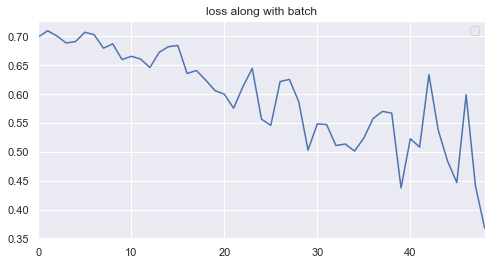

In [18]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

train_loss_df = pd.DataFrame(log_train_loss)
# 每一步取一下
print_df = train_loss_df[0:-1:1]
ax = print_df.plot(figsize=(8,4))
ax.ticklabel_format(useOffset=False)
plt.legend([])
plt.title('loss along with batch')
plt.show(ax)

#### 评价指标 | Evaluation criteria

- **Dice Coefficient**

    - False Positive : False(检测模型不能成功地) Positive (判定出结果是Positive的)

    - False Negative : False(检测模型不能成功地) Negative (判定出结果是Negative的)

    - True Positive : True(检测模型成功地) Positive (判定出结果是Positive的)
    
![example](https://img-blog.csdnimg.cn/20190619210639475.png)

对应公式：
$D S C(A, B)=\dfrac{2|A \cap B|}{|A|+|B|} = \dfrac{2 N_{\text {truepositive}}}{2 N_{\text {true positive}}+N_{\text {false positive}}+N_{\text {false negative}}}$

DICE的公式了，分子代表红色部分的两倍，分母是蓝色+绿色+2*红色。当绿蓝完全重叠时，红=绿=蓝，此时DICE为1，即分数最高。但DICE总是<=1的。

In [19]:
new_experiment = 'UWG_batch4'
experiment = new_experiment

save_path = '../results/' + experiment + '/' 
if not os.path.exists(save_path):
    os.makedirs(save_path)
# logs = open(os.path.join(save_path, 'Log_smallpdac_Votemap_Fold'+str(current_fold+1)+'.txt'), 'w')
print("##################################")
print("Starting Testing ...")
# load_snapshot_path = '../models/dice4/UNet_wsgn_prostate_batch4_iteration_40000.pth'
load_snapshot_path = '../models/dice4/UNet_wsgn_prostate_batch4_iteration_40000.pth'
net.load_state_dict(torch.load(load_snapshot_path))
        
net.eval()
net_parallel = nn.DataParallel(net)
        
dataset = ProstateDataset(list_file = test_list_path, 
                            root_dir = train_data_path,
                            transform = transforms.Compose([
                            Normalization(),
                            ]))
        # 同样载入test_loader
test_loader = torch.utils.data.DataLoader(dataset,
             batch_size=1, shuffle=False,
             num_workers=2)
dscps, dscVs = [], []

for i_sample,sample in enumerate(test_loader):
            
    image, label = sample['image'], sample['label']
            # cur_save_path = os.path.join(save_path, str(i_sample) + '.npz')
    cur_save_path = os.path.join(save_path, 
                        dataset.image_list[i_sample].strip('\r\n') + '_pred')
            
    if not os.path.exists(cur_save_path):
        with torch.no_grad():
            pred = test_single_case_baselineunet(net_parallel, image[0].data.numpy(), 24, (96,96,32), num_classes=num_classes)
            # 保存成 npz
            origin_data_path = os.path.join(test_data_path, dataset.image_list[i_sample].strip('\r\n') + '.npz')
            origin_image = np.load(origin_data_path)['imageA'].astype(np.float32)
            save_label = np.squeeze(label)
            np.savez(cur_save_path, image=origin_image, label=label, pred=pred)
            
    else:    
        tmp = np.load(cur_save_path)
        pred = tmp['pred']

    dscp = []
    # 对于1/2类进行即中心腺体和周围区域进行分割
    for i in range(1, 3):
        dscp.append(dsc(pred == i, label[0].data.numpy() == i))

    print('Case %d : ' % i_sample)
    print('\t DSC : %.4f %.4f' % (dscp[0], dscp[1]))

    dscps.append(dscp)
        
dices = np.array(dscps)
diceA_avg = np.sum(dices, axis=0) / dices.shape[0]
print("DSC A")
print(diceA_avg)

##################################
Starting Testing ...
Case 0 : 
	 DSC : 0.4455 0.8393
Case 1 : 
	 DSC : 0.7345 0.8801
Case 2 : 
	 DSC : 0.7101 0.8262
Case 3 : 
	 DSC : 0.5772 0.8628
Case 4 : 
	 DSC : 0.7364 0.7686
Case 5 : 
	 DSC : 0.6789 0.5789
Case 6 : 
	 DSC : 0.7540 0.7669
Case 7 : 
	 DSC : 0.7197 0.7331
Case 8 : 
	 DSC : 0.5337 0.7097
Case 9 : 
	 DSC : 0.3610 0.9214
DSC A
[0.62511064 0.78870174]


#### 结果可视化 | Result visualization 

In [20]:
res_data_base = '../results/'
res_data_path = res_data_base + experiment
res_data_path

'../results/UWG_batch4'

In [21]:
_, _, _, filelist = count_dir_file(res_data_path)

image = np.load(filelist[1])['image'].astype(np.float32)
label = np.squeeze(np.load(filelist[1])['label'].astype(np.float32))
pred = np.load(filelist[1])['pred'].astype(np.float32)

<Figure size 1440x1440 with 0 Axes>

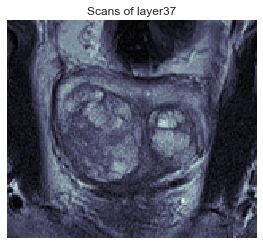

In [22]:
# 查看中间层 image
multi_slice_viewer(image)

<Figure size 1440x5040 with 0 Axes>

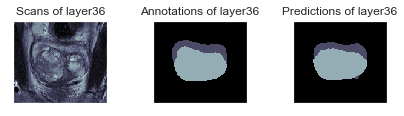

<Figure size 1440x5040 with 0 Axes>

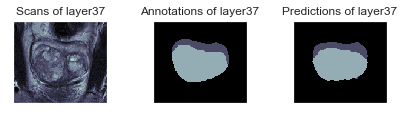

<Figure size 1440x5040 with 0 Axes>

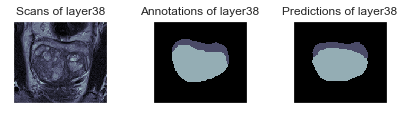

<Figure size 1440x5040 with 0 Axes>

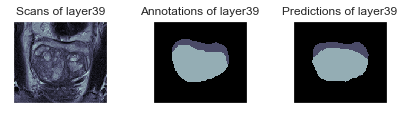

<Figure size 1440x5040 with 0 Axes>

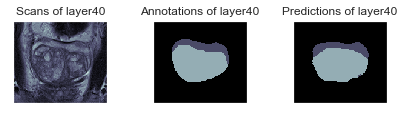

<Figure size 1440x5040 with 0 Axes>

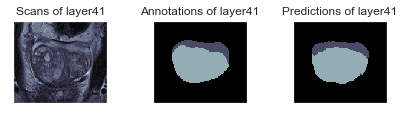

In [23]:
vis_start = 35

for i in range(6):
    multi_slice_viewer(image, label, pred, index = vis_start + i)

- 画出训练过程总图

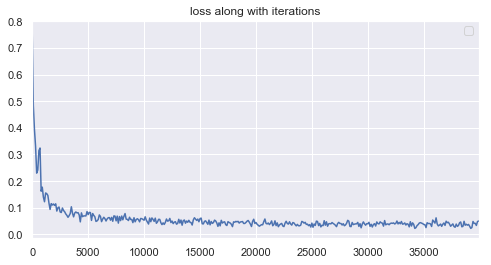

In [25]:
snapshot_path = '../models/dice4'
filename = 'UNet_wsgn_prostate_batch4_iteration_40000'
loss_record_name = os.path.join(snapshot_path, filename + '.txt')
train_loss_df = pd.read_csv(loss_record_name, sep=',', header=None).T
# train_loss_df
step = 100
plot_loss(snapshot_path, filename, step)

#### 充分实验 | Quantitative studies

> 分别取batch size为2,4,6,8,12进行训练，后在测试集上进行测试

![result](./result.png)



| batch=2 |         |        |                 |        |
| ------- | ------- | ------ | --------------- | ------ |
| Case    | UWG-Net |        | U-Net (baseline) |        |
|         | CG DSC  | PZ DSC | CG DSC          | PZ DSC |
| Case0   | 0.3730  | 0.7566 | 0.3191          | 0.7492 |
| Case1   | 0.7636  | 0.8886 | 0.7421          | 0.8802 |
| Case2   | 0.7283  | 0.8226 | 0.7553          | 0.7968 |
| Case3   | 0.5668  | 0.8729 | 0.6275          | 0.8947 |
| Case4   | 0.7075  | 0.7991 | 0.6878          | 0.6774 |
| Case5   | 0.6825  | 0.5973 | 0.6742          | 0.3872 |
| Case6   | 0.7184  | 0.6247 | 0.7052          | 0.7065 |
| Case7   | 0.7162  | 0.6888 | 0.6857          | 0.6756 |
| Case8   | 0.5604  | 0.7836 | 0.6344          | 0.7277 |
| Case9   | 0.3765  | 0.9169 | 0.3423          | 0.924  |
| Average | **0.6193**  | **0.7751** | 0.6174          | 0.7419 |

| batch=4 |         |                 |        |        |
| ------- | ------- | --------------- | ------ | ------ |
| Case    | UWG-Net |        | U-Net (baseline) |        |
|         | CG DSC  | PZ DSC | CG DSC          | PZ DSC |
| Case0   | 0.4455  | 0.8393          | 0.3739 | 0.7547 |
| Case1   | 0.7345  | 0.8801          | 0.7404 | 0.8594 |
| Case2   | 0.7101  | 0.8262          | 0.7645 | 0.8269 |
| Case3   | 0.5772  | 0.8628          | 0.6096 | 0.8643 |
| Case4   | 0.7364  | 0.7686          | 0.6205 | 0.7272 |
| Case5   | 0.6789  | 0.5789          | 0.6799 | 0.5839 |
| Case6   | 0.7540  | 0.7669          | 0.6783 | 0.7356 |
| Case7   | 0.7197  | 0.7331          | 0.6732 | 0.6477 |
| Case8   | 0.5337  | 0.7097          | 0.5425 | 0.7126 |
| Case9   | 0.3610  | 0.9214          | 0.2734 | 0.9214 |
| Average | **0.6251**  | **0.7887**          | 0.5956 | 0.7634 |

| batch=6 |         |                 |            |            |
| ------- | ------- | --------------- | ---------- | ---------- |
| Case    | UWG-Net |        | U-Net (baseline) |        |
|         | CG DSC  | PZ DSC | CG DSC          | PZ DSC |
| Case0   | 0.3545  | 0.7054          | 0.2826     | 0.7516     |
| Case1   | 0.7415  | 0.8766          | 0.6955     | 0.8822     |
| Case2   | 0.6862  | 0.8406          | 0.7522     | 0.8240     |
| Case3   | 0.5197  | 0.8560          | 0.5526     | 0.8586     |
| Case4   | 0.6597  | 0.7565          | 0.6798     | 0.7736     |
| Case5   | 0.6095  | 0.5552          | 0.6931     | 0.5142     |
| Case6   | 0.7000  | 0.5977          | 0.7221     | 0.7543     |
| Case7   | 0.6796  | 0.6811          | 0.6318     | 0.6806     |
| Case8   | 0.4706  | 0.7422          | 0.5826     | 0.6786     |
| Case9   | 0.2877  | 0.9240          | 0.3668     | 0.9149     |
| Average | 0.5709  | 0.7535          | **0.5959** | **0.7633** |


| batch=8 |         |                 |            |            |
| ------- | ------- | --------------- | ---------- | ---------- |
| Case    | UWG-Net |        | U-Net (baseline) |        |
|         | CG DSC  | PZ DSC | CG DSC          | PZ DSC |
| Case0   | 0.2855  | 0.5717          | 0.3585     | 0.7310     |
| Case1   | 0.7360  | 0.8816          | 0.7068     | 0.8653     |
| Case2   | 0.6725  | 0.7973          | 0.7188     | 0.8044     |
| Case3   | 0.6078  | 0.8658          | 0.5659     | 0.8621     |
| Case4   | 0.6043  | 0.6532          | 0.7120     | 0.6872     |
| Case5   | 0.6390  | 0.6174          | 0.6403     | 0.5787     |
| Case6   | 0.6784  | 0.6603          | 0.7205     | 0.7080     |
| Case7   | 0.6863  | 0.6978          | 0.6998     | 0.6404     |
| Case8   | 0.4688  | 0.7029          | 0.5941     | 0.7057     |
| Case9   | 0.3243  | 0.9155          | 0.3384     | 0.9161     |
| Average | 0.5703  | 0.7364          | **0.6055** | **0.7499** |

| batch=12 |         |                 |            |        |
| -------- | ------- | --------------- | ---------- | ------ |
| Case    | UWG-Net |        | U-Net (baseline) |        |
|         | CG DSC  | PZ DSC | CG DSC          | PZ DSC |
| Case0    | 0.2618  | 0.5944          | 0.2733     | 0.5948 |
| Case1    | 0.7323  | 0.8774          | 0.7141     | 0.8715 |
| Case2    | 0.6611  | 0.8341          | 0.7227     | 0.7915 |
| Case3    | 0.5615  | 0.8751          | 0.4744     | 0.8343 |
| Case4    | 0.5045  | 0.7150          | 0.6597     | 0.6376 |
| Case5    | 0.5823  | 0.6018          | 0.6597     | 0.5965 |
| Case6    | 0.6415  | 0.5292          | 0.7502     | 0.6827 |
| Case7    | 0.6773  | 0.7220          | 0.6900     | 0.6859 |
| Case8    | 0.5281  | 0.6703          | 0.5320     | 0.6717 |
| Case9    | 0.2534  | 0.9204          | 0.3669     | 0.9119 |
| Average  | 0.5404  | **0.7340**      | **0.5843** | 0.7278 |


### 总结与未来工作 | Conclusion & Future work 

- 总结

总体而言达到了预期的想法，当batch=4时，整体性能水平达到最优，相比baseline在CG和PZ分别有3%和2%的DSC指标提升

- 展望

    - **研究方面**：
        - 进一步思考为什么 Weight-standardization 在较大batch数可能会失效的可能原因
        - 将本网络进一步拓展到如心、脑、肺等其他3维医疗图像分割问题上，进一步拓展模型的通用性
        - 与疾病诊断，预后等更高阶任务做深入的结合与探索

    - **工程方面**：
        - 探索更加丰富的损失函数与本框架进行结合，充分挖掘3维图像的内在联系
        - 尝试应用于更为性能更加优越的ResU-Net，DenseU-Net和nnU-Net等架构


### 参考文献 | References

[1] Litjens, Geert, et al. "A pattern recognition approach to zonal segmentation of the prostate on MRI." International Conference on Medical Image Computing and Computer-Assisted Intervention. Springer, Berlin, Heidelberg, 2012.

[2] Simpson, Amber L., et al. "A large annotated medical image dataset for the development and evaluation of segmentation algorithms." arXiv preprint arXiv:1902.09063 (2019).

[3] Çiçek, Özgün, et al. "3D U-Net: learning dense volumetric segmentation from sparse annotation." International conference on medical image computing and computer-assisted intervention. Springer, Cham, 2016.

[4] Wu, Yuxin, and Kaiming He. "Group normalization." Proceedings of the European Conference on Computer Vision (ECCV). 2018.

[5] Qiao, Siyuan, et al. "Weight standardization." arXiv preprint arXiv:1903.10520 (2019).

